<a href="https://colab.research.google.com/github/betuldanismaz/RatPoseYOLO/blob/main/RatPoseYOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

labels/train : 10.000-11.000 arasındaki framelerin text dosyaları var
labels/test  : 11.000-11.000 arasında framelerin text dosyaları var

images/train : 10.000-11.000 arasındaki framelerin .png dosyaları var
images/test: 11.000-11.000 arasında framelerin png dosyaları var


In [ ]:
""" DATA PREPARATION İÇİN GEREKLİ KODLAR

base_dir = "/content/drive/MyDrive/cvat_pose_project"
os.makedirs(base_dir, exist_ok=True)

# Alt klasörler
folders = ["images/train", "images/test",
           "labels/train", "labels/test",
           "converted_labels", "frames"]

for folder in folders:
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

print("✅ Klasör yapısı oluşturuldu.")

In [ ]:
#bu kod ile imageler üretiliyor
#10.000-11.000 arası training
#11.000-11.100 arası testing

""" DATA PREPARATION İÇİN GEREKLİ KODLAR
import cv2
import os

video_path = "/content/drive/MyDrive/K12-RAT1-PN14DAY.MOV"
cap = cv2.VideoCapture(video_path)

output_train_dir = "/content/drive/MyDrive/cvat_pose_project/images/train"
output_test_dir = "/content/drive/MyDrive/cvat_pose_project/images/test"
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

start_train, end_train = 10000, 11000
start_test, end_test =11000, 11100

frame_index = 0
success = True

while success:
    success, frame = cap.read()
    if not success:
        break

    if start_train <= frame_index < end_train:
        filename = f"{frame_index:06d}.png"
        cv2.imwrite(os.path.join(output_train_dir, filename), frame)

    elif start_test <= frame_index < end_test:
        filename = f"{frame_index:06d}.png"
        cv2.imwrite(os.path.join(output_test_dir, filename), frame)

    elif frame_index >= end_test:
        break

    frame_index += 1

cap.release()
print("✅ Frame çıkartma tamamlandı.")

"""

In [ ]:
""" DATA PREPARATION İÇİN GEREKLİ KODLAR
import os
import xml.etree.ElementTree as ET

xml_path = "/content/drive/MyDrive/cvat_pose_project/annotations-new.xml"
output_dir = "/content/converted_labels"
os.makedirs(output_dir, exist_ok=True)

tree = ET.parse(xml_path)
root = tree.getroot()

for image in root.findall("image"):
    image_name = image.attrib["name"]
    image_id = os.path.splitext(image_name)[0]
    width = float(image.attrib["width"])
    height = float(image.attrib["height"])
    lines = []

    for points_tag in image.findall("points"):
        label = points_tag.attrib["label"]
        points = points_tag.attrib["points"]
        point_list = points.strip().split(";")

        if len(point_list) < 1:
            continue

        keypoints = []
        for pt in point_list:
            x, y = map(float, pt.strip().split(","))
            x_norm = x / width
            y_norm = y / height
            keypoints.extend([x_norm, y_norm, 2])  # 2: visible

        # eksik keypoint varsa, tamamla (YOLOv8 pose için 17 keypoint gerekir)
        while len(keypoints) < 17 * 3:
            keypoints.extend([0, 0, 0])

        class_id = 0  # varsayalım tek sınıf: rat
        line = f"{class_id} " + " ".join(f"{kp:.6f}" for kp in keypoints)
        lines.append(line)

    if lines:
        with open(os.path.join(output_dir, f"{image_id}.txt"), "w") as f:
            f.write("\n".join(lines))

print("✅ Dönüştürme tamamlandı. Etiketler 'converted_labels' klasörüne kaydedildi.")

In [ ]:
import os

# Klasörü kontrol et ve varsa oluştur
base_dir = '/content/drive/MyDrive/cvat_pose_project'

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    print(f"✅ Klasör oluşturuldu: {base_dir}")
else:
    print(f"✅ Klasör zaten mevcut: {base_dir}")

# data.yaml dosyasını kaydet
data_yaml_content = """
path: /content/drive/MyDrive/cvat_pose_project
train: /content/drive/MyDrive/cvat_pose_project/images/train
val: /content/drive/MyDrive/cvat_pose_project/images/test
nc: 1  # sınıf sayısı, burada 1 sınıf (rat) var
kpt_shape: [16, 3]
names: ['rat']
"""
# Dosyayı kaydedelim
yaml_path = os.path.join(base_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    f.write(data_yaml_content)

print("✅ data.yaml dosyası oluşturuldu.")



✅ Klasör oluşturuldu: /content/drive/MyDrive/cvat_pose_project
✅ data.yaml dosyası oluşturuldu.


In [ ]:
from ultralytics import YOLO
import os



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
base_dir = "/content/drive/MyDrive/cvat_pose_project"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "converted_labels")

print("✅ Eğitim için görüntü klasörü:", images_dir)
print("✅ Etiket klasörü:", labels_dir)


✅ Eğitim için görüntü klasörü: /content/drive/MyDrive/cvat_pose_project/images
✅ Etiket klasörü: /content/drive/MyDrive/cvat_pose_project/converted_labels


In [ ]:
import shutil
import glob

# Eğitim etiketlerini taşı
for label_file in glob.glob(labels_dir + "/*.txt"):
    file_name = os.path.basename(label_file)
    frame_index = int(file_name.split('.')[0])
    if 10000 <= frame_index < 11000:
        shutil.copy(label_file, os.path.join(base_dir, "labels/train", file_name))
    elif 11000 <= frame_index < 11100:
        shutil.copy(label_file, os.path.join(base_dir, "labels/test", file_name))


In [ ]:
yaml_content = """
path: /content/drive/MyDrive/cvat_pose_project/
train: images/train
val: images/test
nc: 1
names: ['rat']
kpt_shape: [16, 3]
"""

with open('/content/drive/MyDrive/cvat_pose_project/data.yaml', 'w') as f:
    f.write(yaml_content)


In [ ]:

from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')  # Hafif model, hızlı çalışır

model.train(
    data='/content/drive/MyDrive/cvat_pose_project/data.yaml',
    epochs=15,
    imgsz=640,
    batch=16,
    name='rat_pose_model'
)



Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/content/drive/MyDrive/cvat_pose_project/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=rat_pose_model7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /content/drive/MyDrive/cvat_pose_project/labels/train... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [04:36<00:00,  3.61it/s]


train: New cache created: /content/drive/MyDrive/cvat_pose_project/labels/train.cache
WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.7±5.0 ms, read: 85.4±68.5 MB/s, size: 1524.1 KB)


val: Scanning /content/drive/MyDrive/cvat_pose_project/labels/test.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/pose/rat_pose_model7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/pose/rat_pose_model7
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G      1.187      9.497     0.6587     0.9681      1.099          9        640: 100%|██████████| 63/63 [15:48<00:00, 15.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<00:00,  5.95s/it]

                   all        100        100      0.999          1      0.995      0.501          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G     0.8139      6.012     0.4913     0.5412     0.9153         13        640: 100%|██████████| 63/63 [15:33<00:00, 14.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<00:00,  5.82s/it]

                   all        100        100      0.999          1      0.995      0.715      0.849       0.78      0.821      0.111



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G     0.7417      4.354     0.3711     0.4994     0.9038         14        640: 100%|██████████| 63/63 [15:44<00:00, 14.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:21<00:00,  5.45s/it]

                   all        100        100      0.999          1      0.995       0.62       0.45       0.45      0.367     0.0378



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G     0.7522      3.822     0.3073     0.4768     0.9105         13        640: 100%|██████████| 63/63 [15:35<00:00, 14.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.62s/it]

                   all        100        100      0.999          1      0.995      0.613      0.859       0.86      0.908      0.302



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G      0.667      3.114     0.2978     0.4442     0.8837         16        640: 100%|██████████| 63/63 [15:35<00:00, 14.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:21<00:00,  5.39s/it]

                   all        100        100      0.999          1      0.995       0.62      0.999          1      0.995      0.327


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G     0.6276      2.284       0.12     0.4163     0.8703         16        640:  29%|██▊       | 18/63 [04:49<12:04, 16.09s/it]


KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO

# Eğitilmiş modeli yükle
model = YOLO('/content/runs/pose/rat_pose_model4/weights/best.pt')



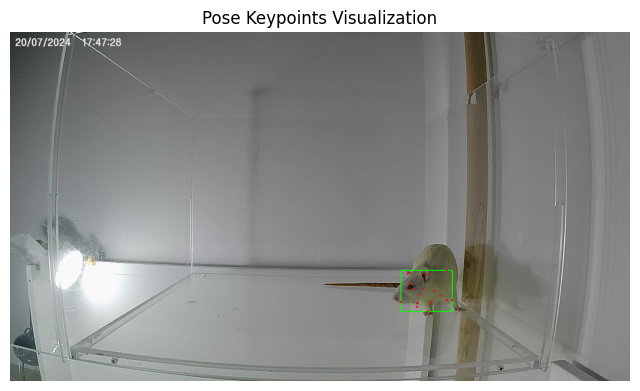

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 🔄 Ayarlar
image_path = '/content/drive/MyDrive/cvat_pose_project/images/train/010669.png'  # örnek görsel
label_path = '/content/drive/MyDrive/cvat_pose_project/labels/train/010669.txt'  # aynı isimli etiket

# 1️⃣ Görseli yükle
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# 2️⃣ Etiketleri oku
with open(label_path, 'r') as f:
    lines = f.readlines()

# 3️⃣ Her etiketi çiz
for line in lines:
    parts = list(map(float, line.strip().split()))
    cls, x, y, bw, bh = parts[:5]
    kpts = parts[5:]

    # Bounding box'u çiz
    x1 = int((x - bw / 2) * w)
    y1 = int((y - bh / 2) * h)
    x2 = int((x + bw / 2) * w)
    y2 = int((y + bh / 2) * h)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Keypoint'leri çiz
    for i in range(0, len(kpts), 3):
        kx = int(kpts[i] * w)
        ky = int(kpts[i+1] * h)
        v = int(kpts[i+2])
        color = (255, 0, 0) if v > 0 else (128, 128, 128)  # görünürse mavi, değilse gri
        cv2.circle(img, (kx, ky), 3, color, -1)

# 4️⃣ Görseli göster
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Pose Keypoints Visualization")
plt.show()


In [ ]:
# Tüm test görselleri üzerinde tahmin
results = model.predict(
    source='/content/drive/MyDrive/cvat_pose_project/images/test',
    save=True,  # Tahmin görsellerini kaydeder
    imgsz=640,
    conf=0.25  # Güven eşiği
)



image 1/100 /content/drive/MyDrive/cvat_pose_project/images/test/011000.png: 384x640 1 rat, 229.4ms
image 2/100 /content/drive/MyDrive/cvat_pose_project/images/test/011001.png: 384x640 1 rat, 208.3ms
image 3/100 /content/drive/MyDrive/cvat_pose_project/images/test/011002.png: 384x640 1 rat, 203.9ms
image 4/100 /content/drive/MyDrive/cvat_pose_project/images/test/011003.png: 384x640 1 rat, 212.0ms
image 5/100 /content/drive/MyDrive/cvat_pose_project/images/test/011004.png: 384x640 1 rat, 203.3ms
image 6/100 /content/drive/MyDrive/cvat_pose_project/images/test/011005.png: 384x640 1 rat, 216.3ms
image 7/100 /content/drive/MyDrive/cvat_pose_project/images/test/011006.png: 384x640 1 rat, 212.0ms
image 8/100 /content/drive/MyDrive/cvat_pose_project/images/test/011007.png: 384x640 1 rat, 212.5ms
image 9/100 /content/drive/MyDrive/cvat_pose_project/images/test/011008.png: 384x640 1 rat, 134.9ms
image 10/100 /content/drive/MyDrive/cvat_pose_project/images/test/011009.png: 384x640 1 rat, 136.7m

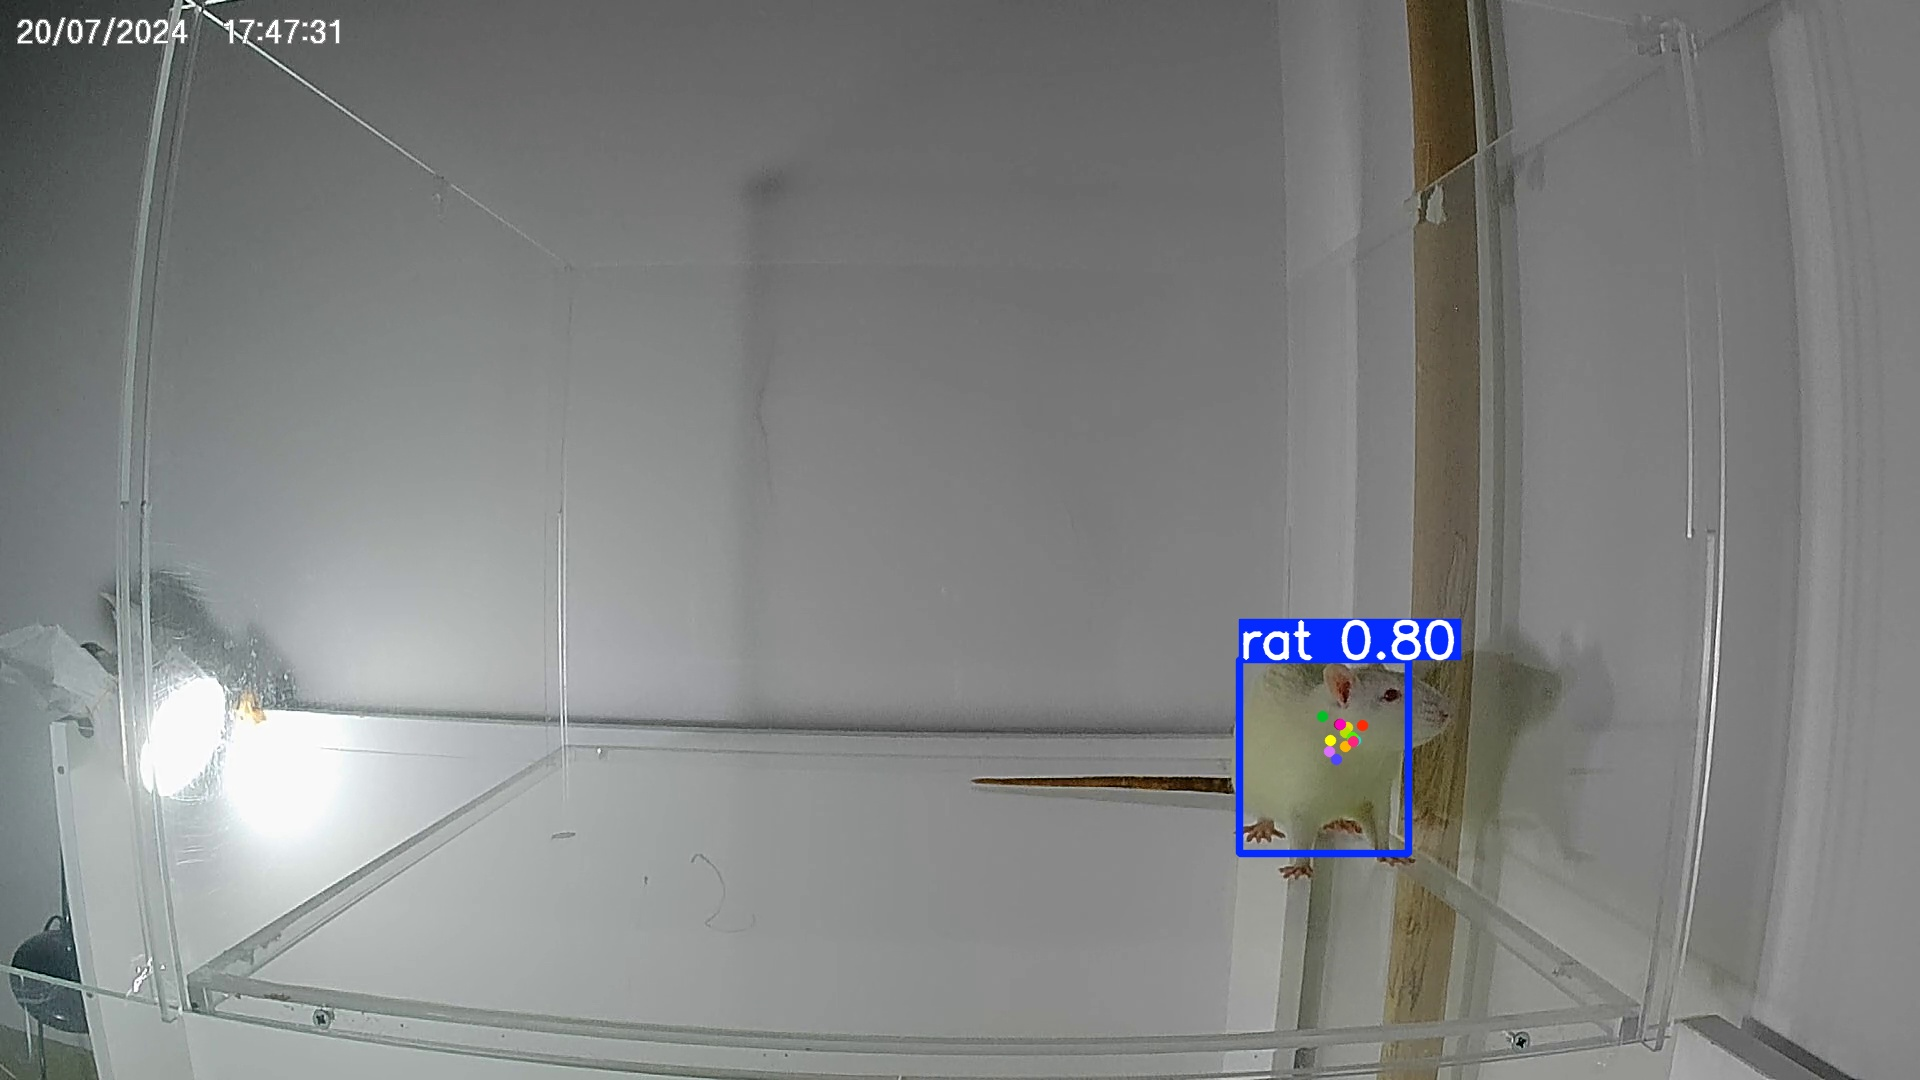

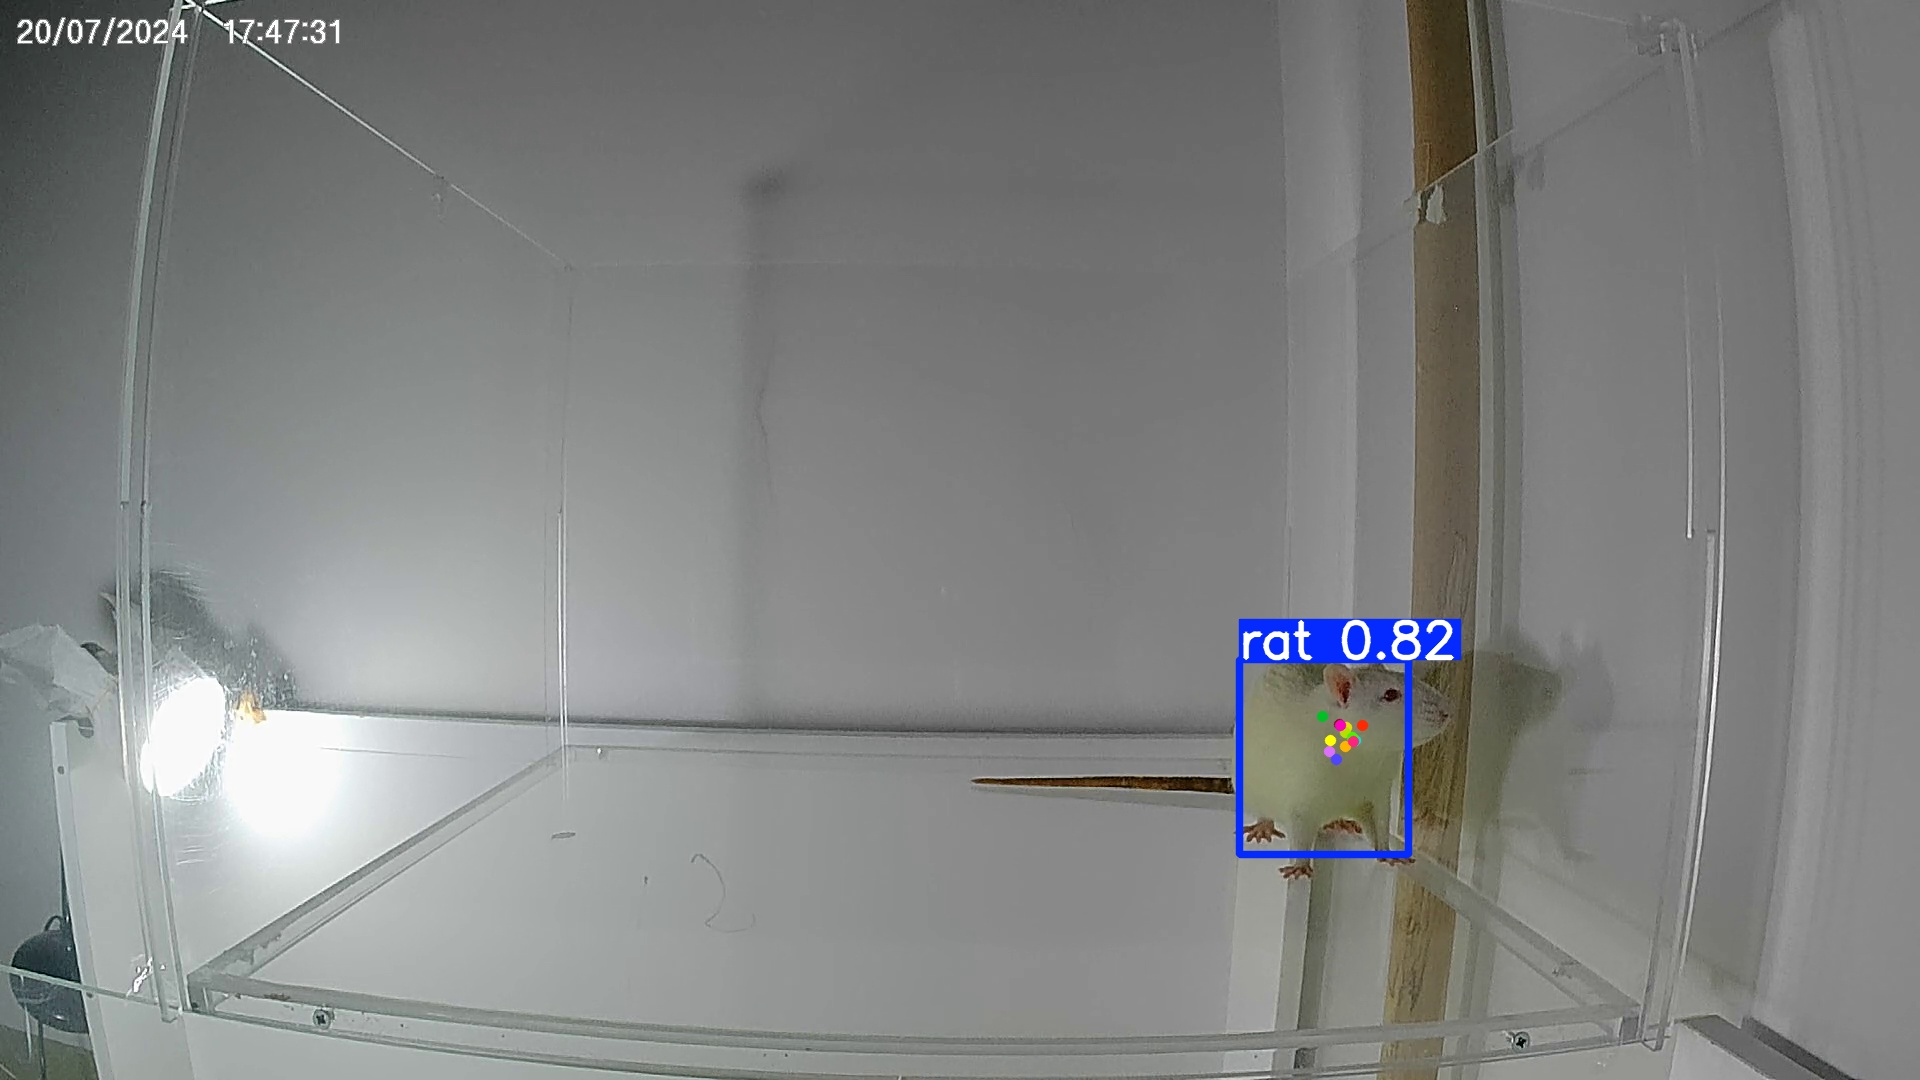

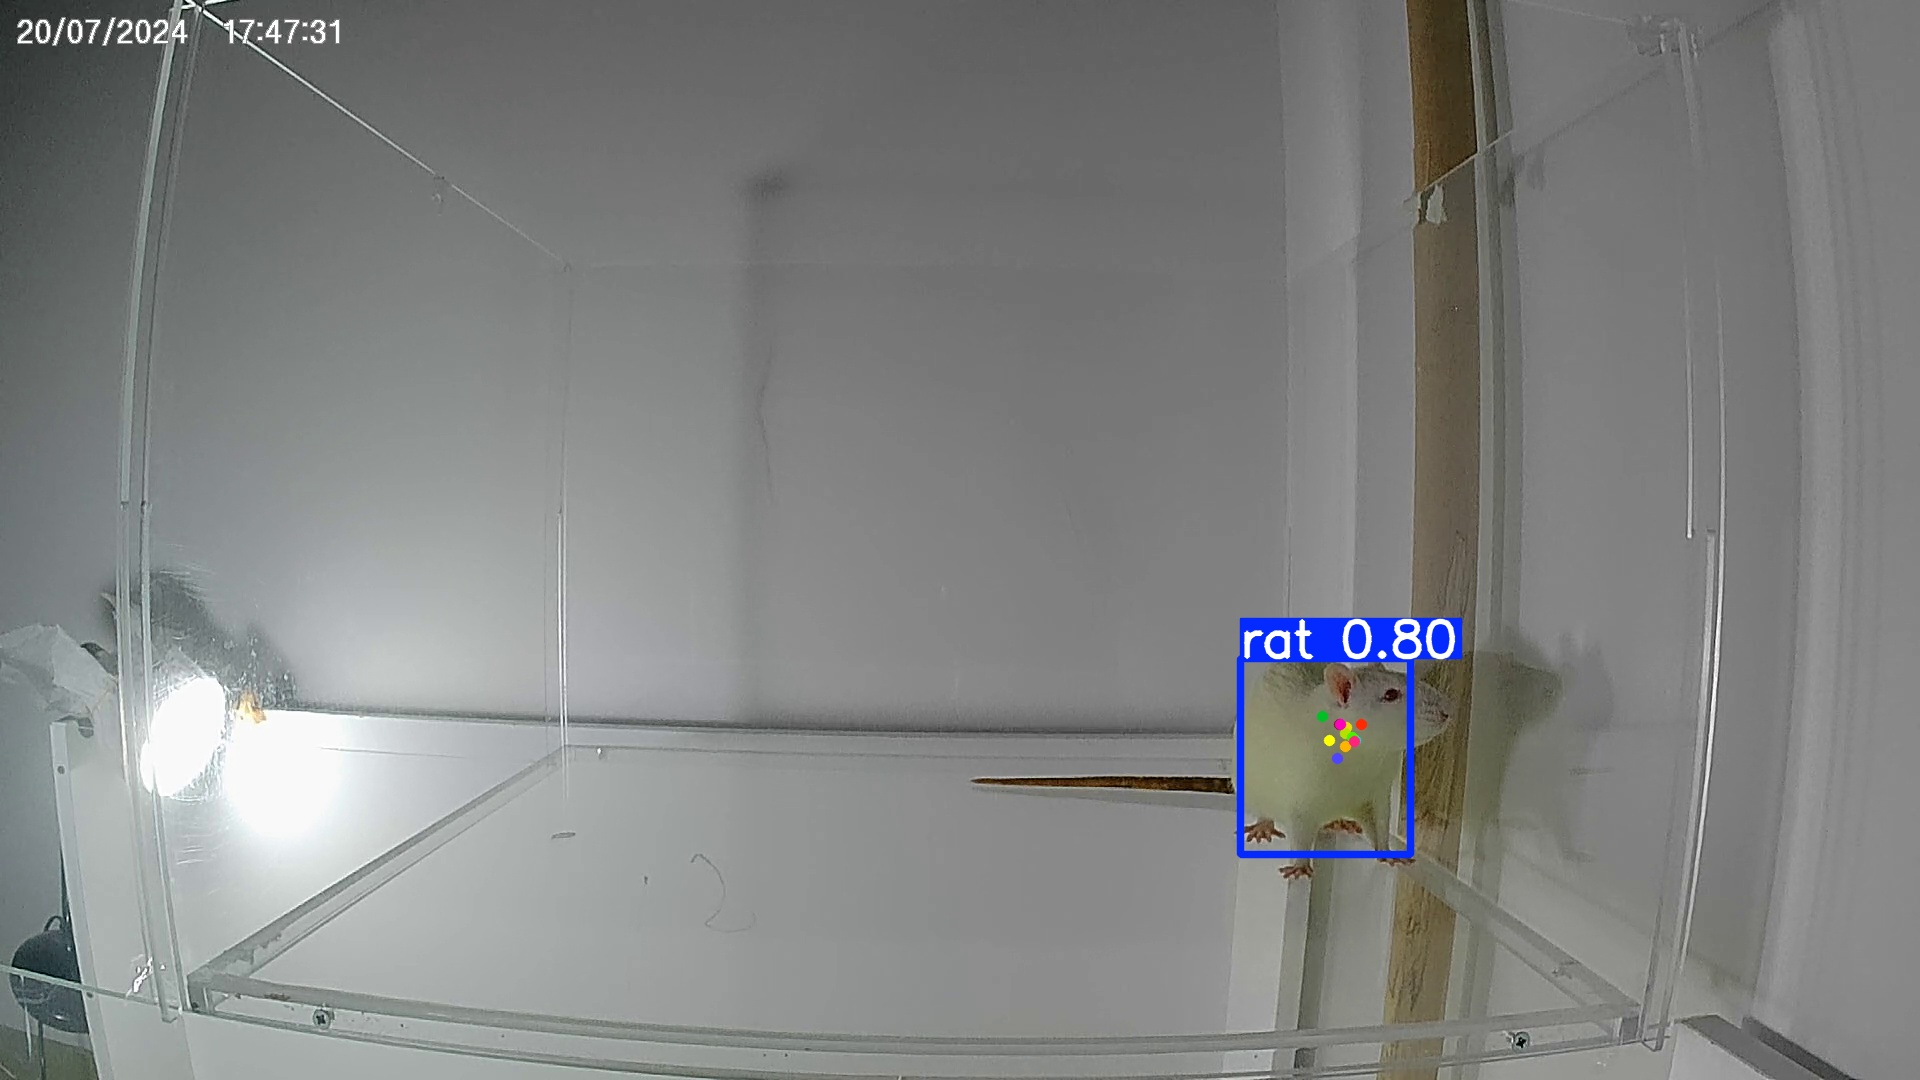

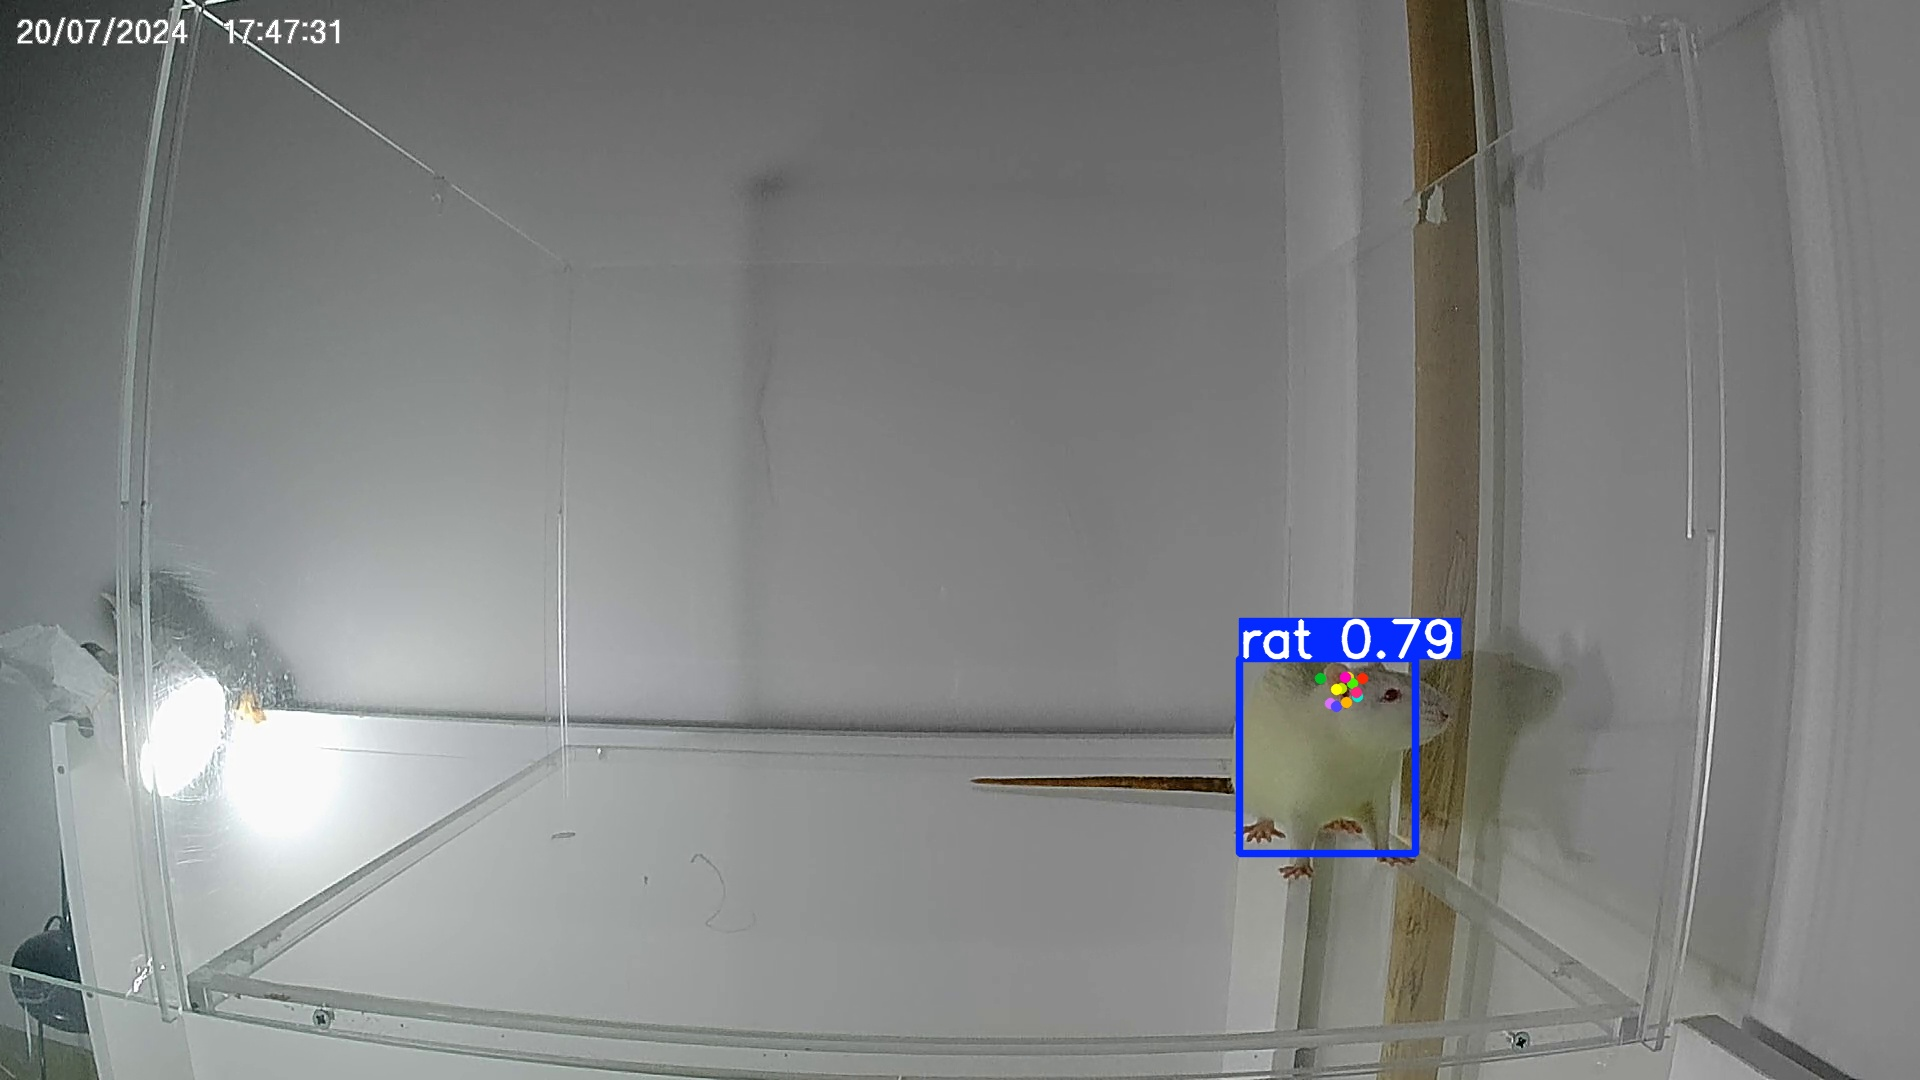

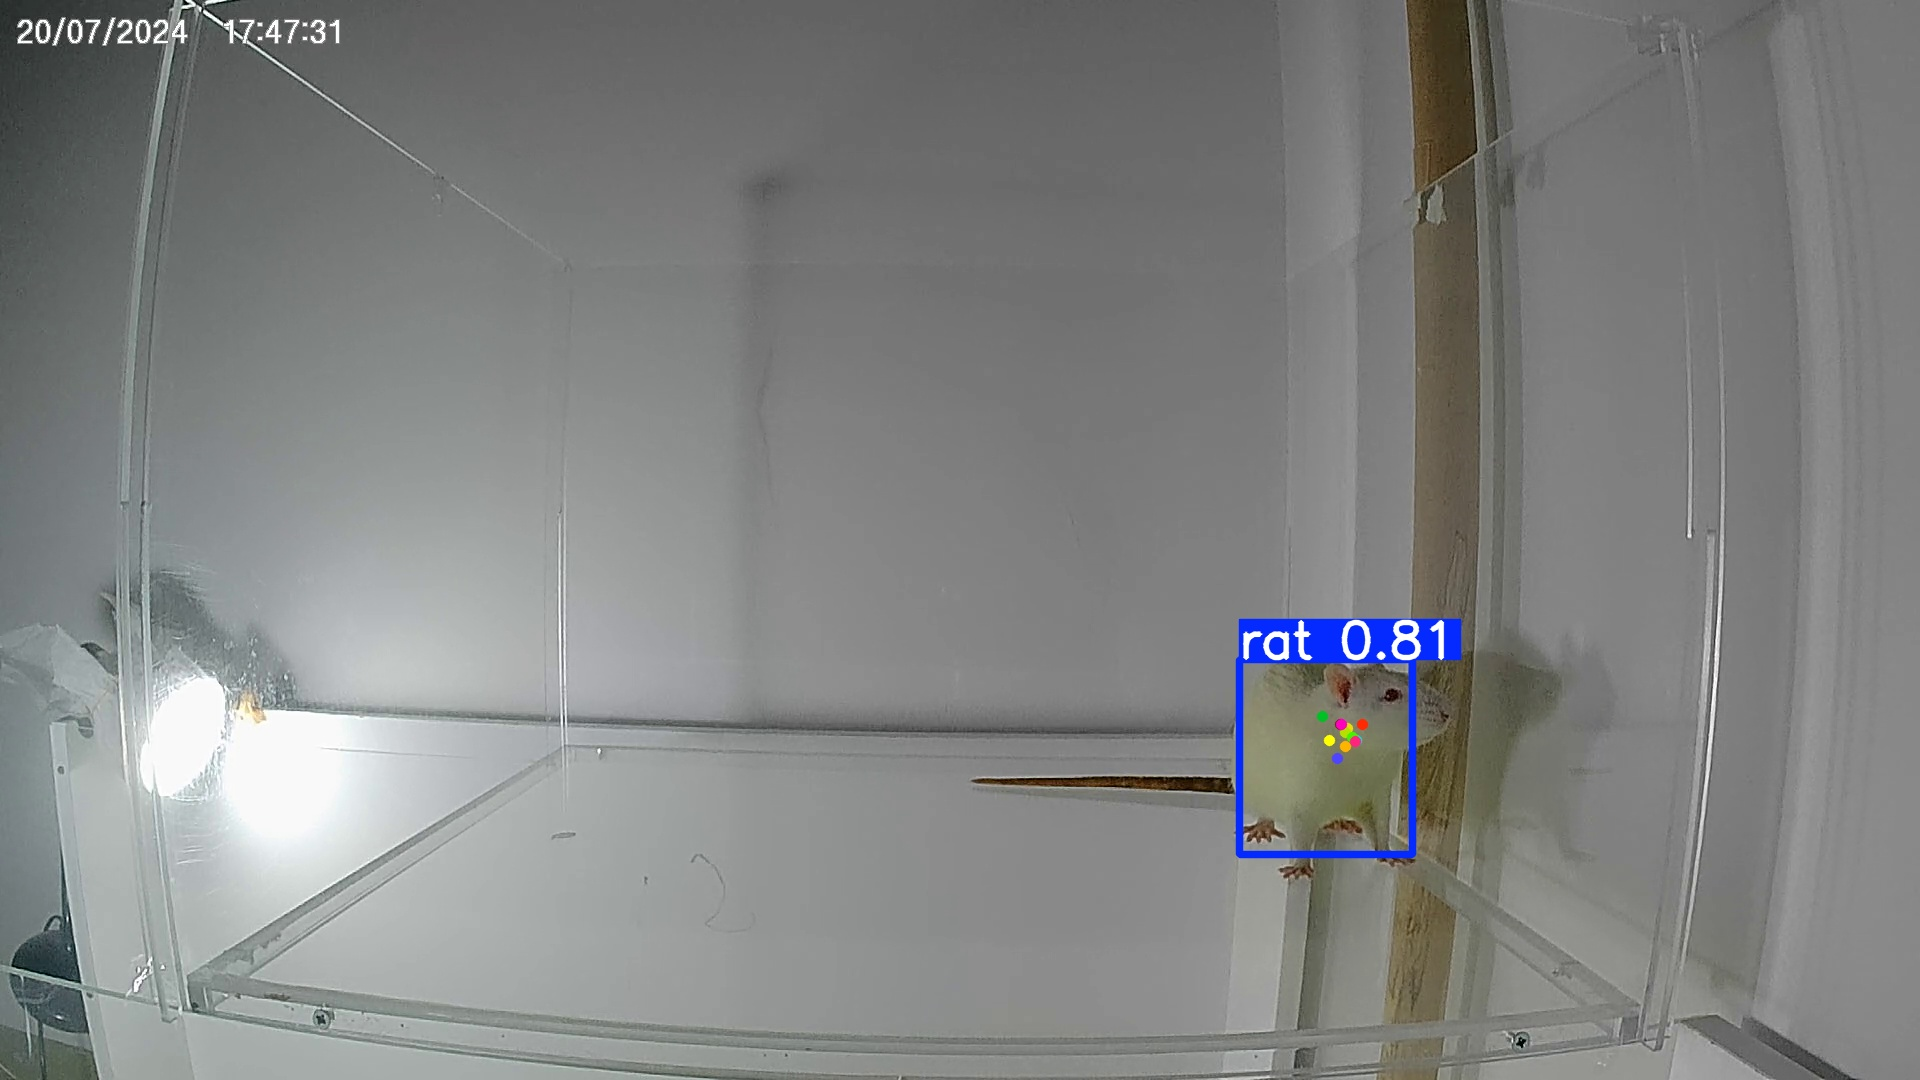

In [ ]:
import os
from IPython.display import Image, display
from PIL import Image as PILImage

pred_dir = '/content/runs/pose/predict'  # Tahminlerin bulunduğu klasör

# Dosyaları sırala ve ilk 5 görüntüyü al
image_files = sorted([f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))])[:5]

# Görselleri sırayla göster
for img_file in image_files:
    img_path = os.path.join(pred_dir, img_file)
    try:
        # PIL ile görsel yüklenip varlığı test ediliyor
        PILImage.open(img_path)
        display(Image(filename=img_path))
    except Exception as e:
        print(f"Görsel gösterilemedi: {img_file} -> {e}")


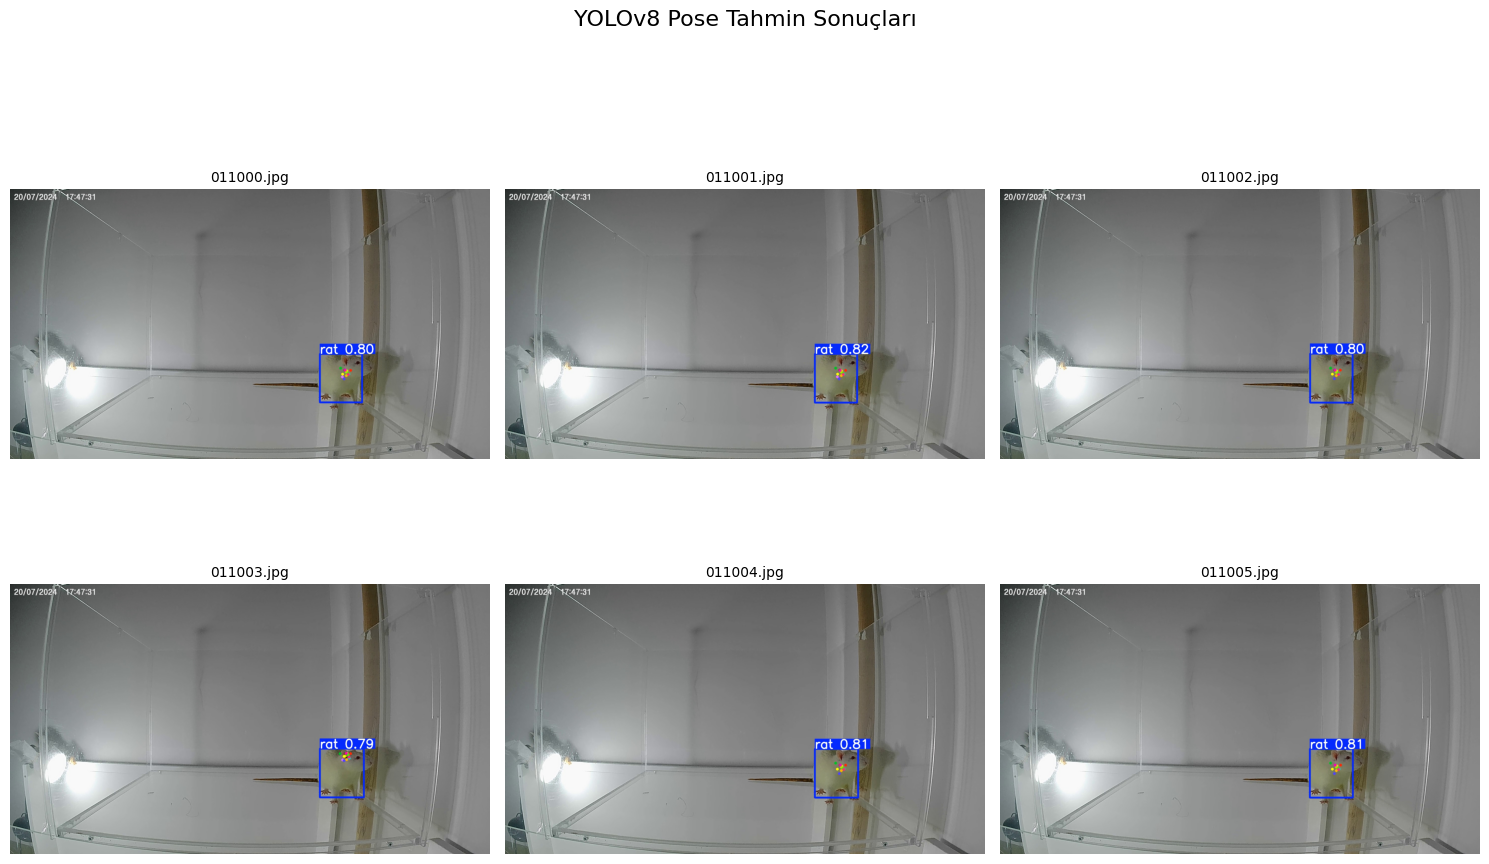

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pred_dir = '/content/runs/pose/predict'  # Tahmin sonuçlarının bulunduğu klasör

# Dosya listesini al ve filtrele
image_files = sorted([f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))])[:6]  # İlk 6 görsel

# Grid boyutu (2 satır, 3 sütun)
rows, cols = 2, 3

# Görselleri çiz
plt.figure(figsize=(15, 10))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(pred_dir, img_file)
    img = mpimg.imread(img_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(img_file, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("YOLOv8 Pose Tahmin Sonuçları", fontsize=16)
plt.subplots_adjust(top=0.92)  # Başlık için boşluk
plt.show()


In [ ]:

model_path = '/content/drive/MyDrive/cvat_pose_project/rat_pose_model_best.pt'
model.save(model_path)


In [ ]:
!yolo export model=yolov8n-pose.pt format=onnx imgsz=640 batch=1


Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-pose summary (fused): 81 layers, 3,289,964 parameters, 0 gradients, 9.2 GFLOPs

PyTorch: starting from 'yolov8n-pose.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 56, 8400) (6.5 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.51...
ONNX: export success ✅ 1.9s, saved as 'yolov8n-pose.onnx' (12.8 MB)

Export complete (2.6s)
Results saved to /content
Predict:         yolo predict task=pose model=yolov8n-pose.onnx imgsz=640  
Validate:        yolo val task=pose model=yolov8n-pose.onnx imgsz=640 data=/usr/src/app/ultralytics/datasets/coco-pose.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export
